In [13]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

# For inline plotting (Jupyter notebooks)
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Device: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Named tuple to store transitions for replay
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Replay Memory for experience replay
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Store a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [15]:
# Single DQN architecture
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [16]:
# Create the environment in "rgb_array" mode for video recording
# Wrap it with RecordVideo, triggering recording every 50 episodes
from gym.wrappers import RecordVideo
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env = RecordVideo(
    env, 
    video_folder='./video_mountain_car', 
    episode_trigger=lambda episode_id: (episode_id + 1) % 50 == 0
)

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0     # Start with a high epsilon for exploration
EPS_END = 0.01      # Final epsilon after decay
EPS_DECAY = 500     # Decay rate
TAU = 0.01          # Soft update rate for the target network
LR = 1e-3
MEMORY_SIZE = 20000
NUM_EPISODES = 500  # Enough episodes to see improvements

# Determine action & state dimensions
initial_state, info = env.reset()
n_actions = env.action_space.n
n_observations = len(initial_state)

# Create the policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_SIZE)
scheduler = StepLR(optimizer, step_size=50, gamma=0.95)

steps_done = 0

c:\Users\Joova\anaconda3\envs\tf\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\Joova\OneDrive\Documents\GitHub\Reinforcement-Learning\Classic Control\Mountain Car\DQN\video_mountain_car folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [17]:
def select_action(state):
    """Epsilon-greedy strategy."""
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    """Perform one step of optimisation."""
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Construct batch tensors
    non_final_mask = torch.tensor(
        tuple(s is not None for s in batch.next_state),
        device=device, dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s, a) using policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # SINGLE DQN: directly use target_net for next state
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        q_values_next = target_net(non_final_next_states)
        next_state_values[non_final_mask] = q_values_next.max(1)[0]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    # Optional gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 10)
    optimizer.step()

# Track the rewards for plotting
episode_rewards = []

def plot_rewards(show_result=False):
    """Plot episode rewards and 100-episode average."""
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Training Results')
    else:
        plt.clf()
        plt.title(f'Training... Episode {len(episode_rewards)}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy(), label='Reward per Episode')
    
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label='100-Episode Average')
        plt.legend()
    plt.pause(0.001)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Training Complete


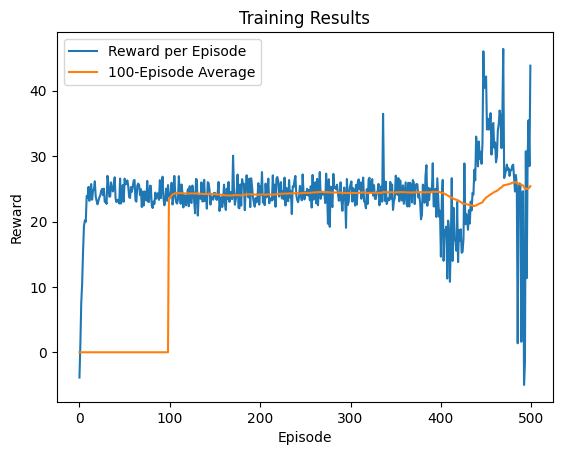

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
# Main training loop
for i_episode in range(NUM_EPISODES):
    # Reset environment and state
    obs, _ = env.reset()
    obs = torch.tensor([obs], device=device, dtype=torch.float32)
    total_reward = 0

    for t in count():
        # Select action
        action = select_action(obs)
        next_obs, reward, terminated, truncated, _ = env.step(action.item())

        # Reward shaping: nudge to move right & big bonus on goal
        position, velocity = next_obs
        shaped_reward = position + 0.5
        if position >= env.goal_position:
            shaped_reward += 10.0

        total_reward += shaped_reward

        done = terminated or truncated
        next_obs = None if done else torch.tensor([next_obs], device=device, dtype=torch.float32)

        # Store in replay memory
        memory.push(obs, action, next_obs, torch.tensor([shaped_reward], device=device))

        obs = next_obs

        # Optimize
        optimize_model()

        # Soft update of target_net
        for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)

        if done:
            episode_rewards.append(total_reward)
            plot_rewards()
            break

    # Step the LR scheduler
    scheduler.step()

print("Training Complete")
plot_rewards(show_result=True)
plt.ioff()
plt.show()



In [12]:
# save the best-performing policy
torch.save(policy_net.state_dict(), 'best_model_mountain_car.pth')

# Close the environment gracefully
env.close()
print("Videos saved every 50 episodes in the 'video_mountain_car' folder.")

Videos saved every 50 episodes in the 'video_mountain_car' folder.
